# Part I

## Question 1

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

#### Load the data (dimaond dataset)

In [2]:
raw_df = pd.read_csv("diamonds.csv")
raw_df = raw_df.drop(columns=["Unnamed: 0"])

#### numerical encoding for categorical features

In [3]:
cut_raw_to_num = {
    "Fair": 1,
    "Good": 2,
    "Very Good": 3,
    "Premium": 4,
    "Ideal": 5
}
color_raw_to_num = {
    "J": 1,
    "I": 2,
    "H": 3,
    "G": 4,
    "F": 5,
    "E": 6,
    "D": 7,
}
clarity_raw_to_num = {
    "I1": 1,
    "SI2": 2,
    "SI1": 3,
    "VS2": 4,
    "VS1": 5,
    "VVS2": 6,
    "VVS1": 7,
    "IF": 8
}
all_raw_to_num = {
    **cut_raw_to_num,
    **color_raw_to_num,
    **clarity_raw_to_num
}

In [4]:
df = raw_df.replace(all_raw_to_num)

### Question 1.1

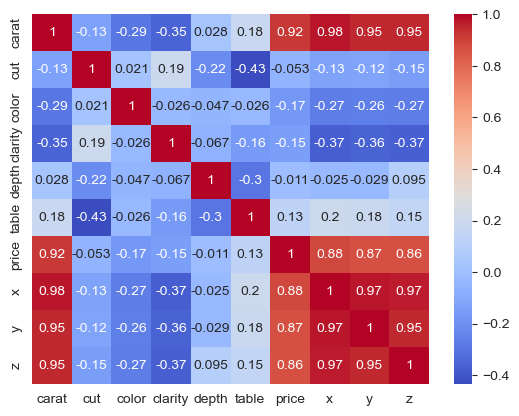

In [5]:
q1_1_corr = df.corr(method='pearson')
sns.heatmap(q1_1_corr, annot=True, cmap="coolwarm")
plt.show()

In [6]:
q1_1_highest = q1_1_corr['price'].abs().sort_values(ascending=False).index[1]
print("Feature with highest absolute correlation with the target variable: " + q1_1_highest)

Feature with highest absolute correlation with the target variable: carat


The correlation pattern suggests strong relationship between weight and size of a dimond and its price.

### Question 1.2

#### Plot of histogram of numerical features (originally)

In [7]:
q1_2_original_num_col = [
    "carat",
    "depth",
    "table",
    "x",
    "y",
    "z"
]

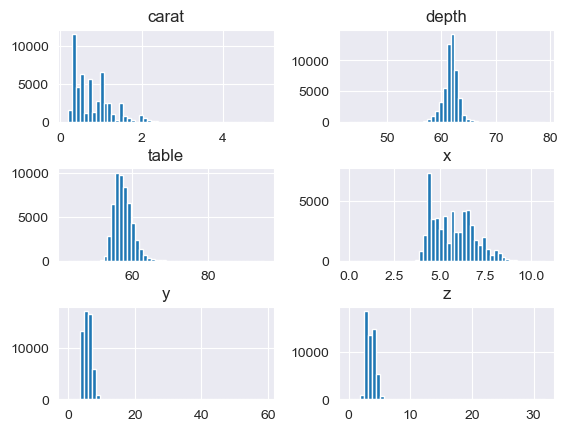

In [8]:
df[q1_2_original_num_col].hist(bins=50)
plt.subplots_adjust(hspace=0.5) 
plt.show()

#### Plot of histogram of numerical features (categorical features converted)

In [9]:
q1_2_categorical_num_col = [
    "cut",
    "color",
    "clarity"
]

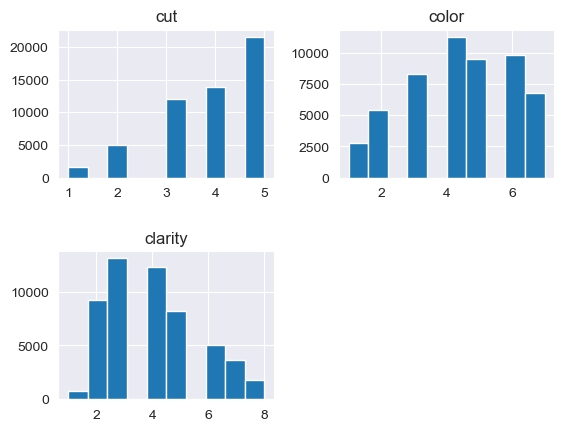

In [10]:
df[q1_2_categorical_num_col].hist()
plt.subplots_adjust(hspace=0.5) 
plt.show()

If the distribution of a feature has high skewness, we can perform a square root transformation, which takes the square root for each value in the feature. This only applies to non negative values which fits our dataset greatly if there is high skewness.

### Question 1.3

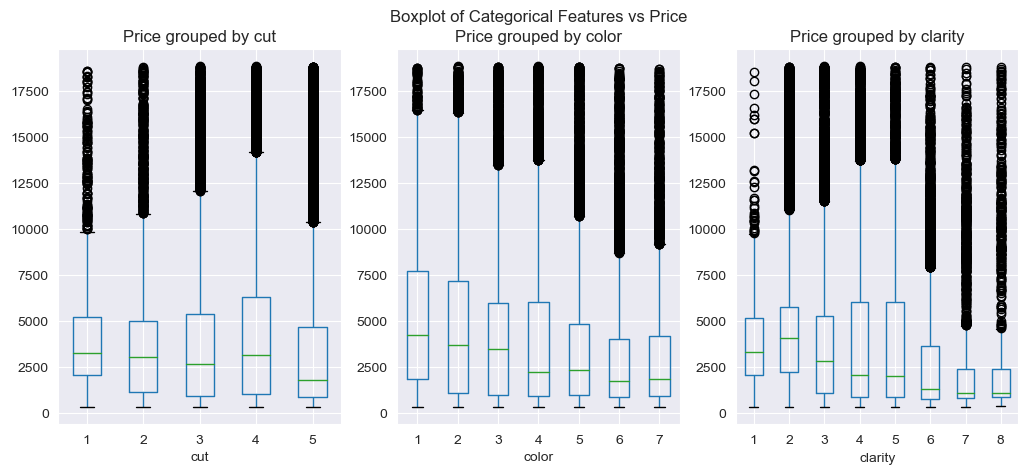

In [11]:
q1_3_cat_col = [
    "cut",
    "color",
    "clarity"
]
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
for i in range(len(q1_3_cat_col)):
    fet_name = q1_3_cat_col[i]
    df[[fet_name, "price"]].boxplot(by=[fet_name], ax=ax[i])
    ax[i].title.set_text('Price grouped by ' + fet_name)
    ax[i].set_xlabel(fet_name)

fig.suptitle('Boxplot of Categorical Features vs Price')
plt.show()

As we can see from the boxplots above, it's counter intuitive that as cut/color/clarity increases in the better direction, the price actually decreases, however, one important fact is the target feature is price not unit price. We will show later that as three features grows in better direction, the unit price actually increases as we'd expected.

### Question 1.4

#### Plot of counts by color, cut, clarity with original labels

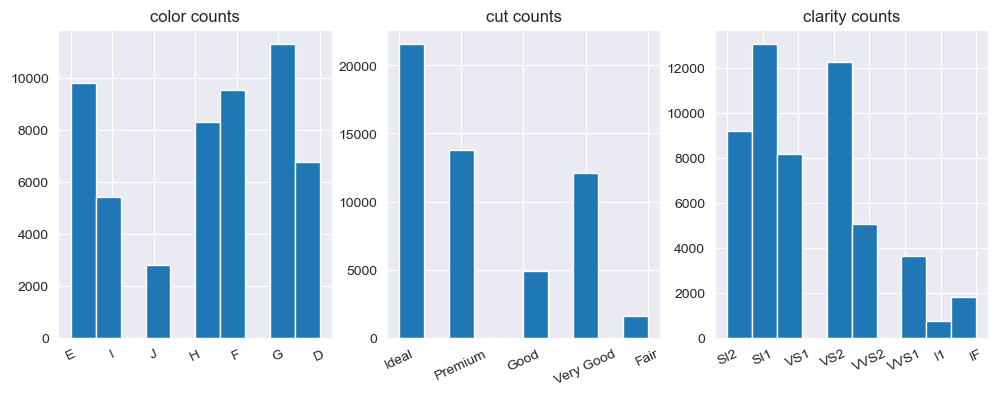

In [12]:
q1_4_cols = ["color", "cut", "clarity"]
fig, ax = plt.subplots(1, len(q1_4_cols), figsize=(12, 4))

for i in range(len(q1_4_cols)):
    raw_df[q1_4_cols[i]].hist(ax=ax[i])
    ax[i].title.set_text(q1_4_cols[i] + " counts")
    ax[i].tick_params("x", labelrotation=25)
    
plt.show()

## Question 2

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression

### Question 2.1

In [14]:
q2_1_scaler = StandardScaler()
df[q1_2_original_num_col] = q2_1_scaler.fit_transform(df[q1_2_original_num_col])
df[q1_2_categorical_num_col] = q2_1_scaler.fit_transform(df[q1_2_categorical_num_col])

### Question 2.2

#### Mutual Information

In [15]:
q2_2_mut_res = mutual_info_regression(df[q1_2_original_num_col + q1_2_categorical_num_col], df["price"])

In [16]:
pd.DataFrame(list(zip(q1_2_original_num_col + q1_2_categorical_num_col, q2_2_mut_res)),
             columns=["Feature", "Estimated Mutual Information"]).set_index("Feature")

,Estimated Mutual Information
Feature,
carat,1.655434
depth,0.030518
table,0.032906
x,1.412225
y,1.421402
z,1.363155
cut,0.057657
color,0.136499
clarity,0.216049


#### F Score

In [17]:
q2_2_f_score, _ = f_regression(df[q1_2_original_num_col + q1_2_categorical_num_col], df["price"])

In [18]:
pd.DataFrame(list(zip(q1_2_original_num_col + q1_2_categorical_num_col, q2_2_f_score)),
             columns=["Feature", "F Score"]).set_index("Feature")

,F Score
Feature,
carat,304051.486618
depth,6.115863
table,886.119363
x,193741.523066
y,160915.662263
z,154923.266553
cut,154.784468
color,1654.401244
clarity,1188.007065


## Question 2.2

This step is cruical because it affects the performance of all our models. If we select features that are not significant in predicting the price of a diamond, we may not get an as accurate prediction, while using a lot of computation power. If we select the right number of features ad taking into consideration which ones are most important, we should be able to train a model with a low rmse. This is only true for regression models. The two lowest mutual information score are the two variables depth and table. 

# Question 3 

In a random forest, there are bootstrapped samples of the training set, and with this, there some rows of the training set that are left out of particular decision trees. The OOB score is the number of correctly predicted rows that were left out of the bag. There are many advantages of the OOB score, for instance, it has less variance and requires less computing power. 

The $R^2$ metric is a value between 0 and 1 that determines where the model is a good fit for the data, i.e how much of the data's variance can it explain.

When evaluating a random forest model, the OOB score is often more accurate and more useful. 

## Training and Testing of Different Models

In [19]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.neural_network import MLPRegressor

In [20]:
feat_cols = q1_2_original_num_col + q1_2_categorical_num_col

##########HERE CHANGE
feat_cols = ['carat', 'table', 'x', 'y', 'z', 'color', 'clarity']

targ_col = "price"
kfold = KFold(n_splits=10)

In [21]:
def do_model(model, param_grid={}, df=df, verbose=0):
    grid = GridSearchCV(
        model,
        param_grid,
        cv=10,
        scoring="neg_root_mean_squared_error",
        return_train_score=True,
        n_jobs=-1,
        verbose=verbose)
    grid = grid.fit(df[feat_cols], df[targ_col])
    grid.avg_train_rmse = list(map(lambda x: -x, grid.cv_results_["mean_train_score"]))
    grid.avg_test_rmse = list(map(lambda x: -x, grid.cv_results_["mean_test_score"]))
    return grid

### Linear Regression

#### Ordinary Least Squares regression

In [22]:
ols = do_model(LinearRegression())

#### Lasso regression

In [23]:
lasso = do_model(Lasso())

#### Ridge regression

In [24]:
ridge = do_model(Ridge())

### Question 4.1

In [25]:
pd.DataFrame({
    "Feature": feat_cols,
    "OLS": ols.best_estimator_.coef_,
    "Lasso": lasso.best_estimator_.coef_,
    "Ridge": ridge.best_estimator_.coef_
}).set_index("Feature")

,OLS,Lasso,Ridge
Feature,,,
carat,5085.348104,5039.562081,5082.899769
depth,-92.337499,-89.174239,-92.209558
x,-954.649062,-909.594286,-952.252907
cut,164.609641,163.834461,164.602501
color,549.355914,547.353154,549.286561
clarity,830.255965,830.169575,830.276261


Based on the above data, the absolute value of all coefficients are low for Lasso (L1) regression. It remains similar for Ridge (L2) regression compared with OLS.

### Question 4.2

In [26]:
q4_2_reg_mult = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
q4_2_ols = do_model(LinearRegression())
q4_2_lasso = do_model(Lasso(), {"alpha": q4_2_reg_mult})
q4_2_ridge = do_model(Ridge(), {"alpha": q4_2_reg_mult})

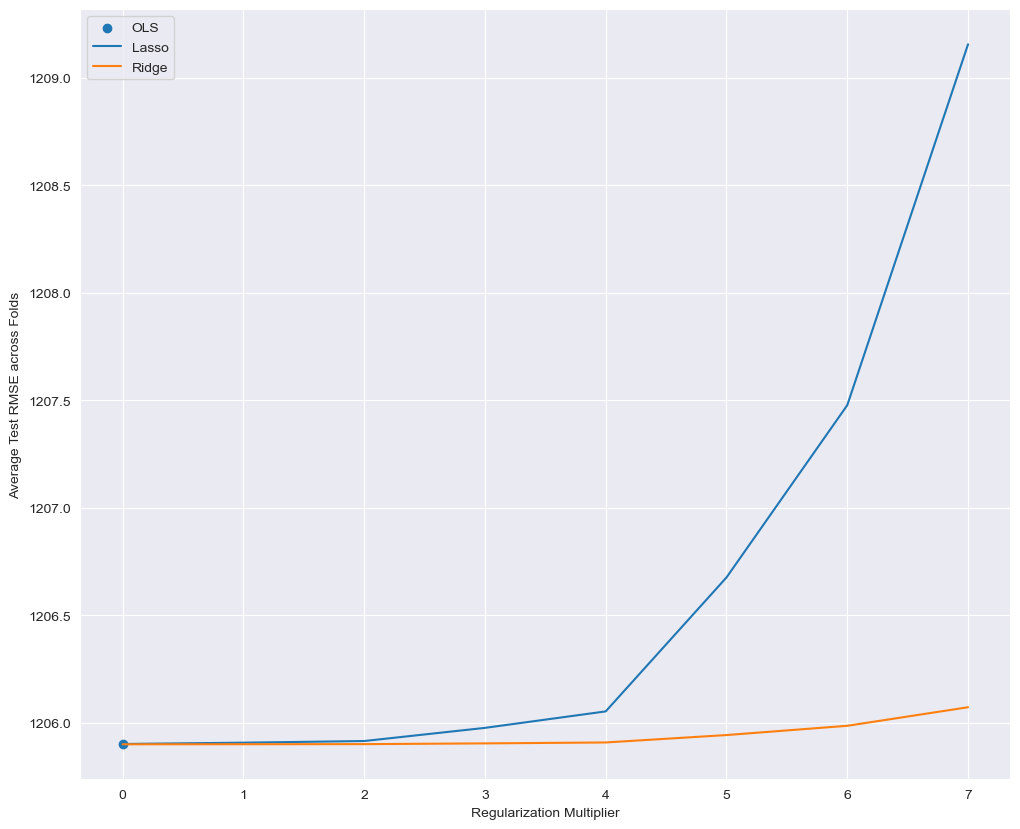

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))

ax.scatter(0, q4_2_ols.avg_test_rmse[0], label="OLS")
x = range(len(q4_2_reg_mult))
ax.plot(x, q4_2_lasso.avg_test_rmse, label="Lasso")
ax.plot(x, q4_2_ridge.avg_test_rmse, label="Ridge")

plt.xlabel("Regularization Multiplier")
plt.ylabel("Average Test RMSE across Folds")

plt.legend()
plt.show()

As we can see in the graph, regularization only increase the RMSE, so the best regularization scheme is no regularization.

### Question 4.3

In [28]:
non_stand_df = raw_df.replace(all_raw_to_num)

In [29]:
q4_3_alpha_list = list(map(lambda x: 0.1*x, range(21)))
q4_3_non_stand_models = do_model(Ridge(), {"alpha": q4_3_alpha_list}, df=non_stand_df)
q4_3_stand_models = do_model(Ridge(), {"alpha": q4_3_alpha_list}, df=df)

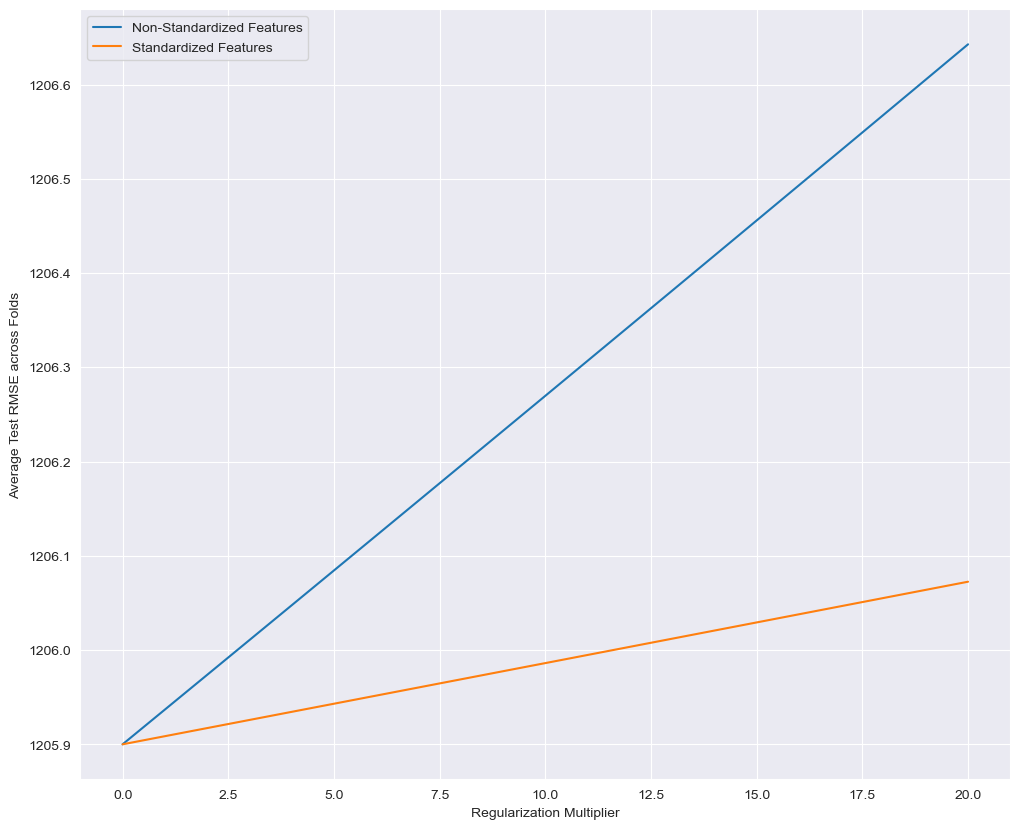

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))

x = range(21)
ax.plot(x, q4_3_non_stand_models.avg_test_rmse, label="Non-Standardized Features")
ax.plot(x, q4_3_stand_models.avg_test_rmse, label="Standardized Features")

plt.xlabel("Regularization Multiplier")
plt.ylabel("Average Test RMSE across Folds")

plt.legend()
plt.show()

Feature standardization helps performance, but really minor. As we can see in the above plot.

### Question 4.4

The p-value is the probability of observing a value that is equal to 0, in other words, whether a specific feature will add information into our model, significant or not. To determine the most significant features, we can use a threshold for the p-vale and whether it is below a threshold, then the probability of it being 0, is very low. 

In [31]:
import itertools
from sklearn.model_selection import GridSearchCV
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

## Polynomial Regression

### Question 5.1

In [32]:
pipe = Pipeline([
    ("poly", PolynomialFeatures()),
    ("ridge", Ridge())
])

param = {
    "poly__degree": [1, 2, 3, 4, 5, 6]
}

In [33]:
grid = GridSearchCV(pipe, param_grid = param, cv = 10, n_jobs = -1, 
                    scoring = 'neg_root_mean_squared_error')
X = df[feat_cols]
y = df[targ_col]
grid.fit(X, y)

df_rdg = pd.DataFrame({"Best Polynomial Regression": [grid.best_estimator_, 
                                                      grid.best_params_, 
                                                      np.sqrt(-1 * grid.best_score_)]})
df_rdg.index = ["Best Estimator", "Best Parameters", "RMSE"]
df_rdg

,Best Polynomial Regression
Best Estimator,"(PolynomialFeatures(degree=3), Ridge())"
Best Parameters,{'poly__degree': 3}
RMSE,25.719061


The top 5 most salient features from the features that we had picked out turned out to be clarity, x, carat, cut, and color.

### Question 5.2

We used a grid search with a 10-fold cross validation across varying degress from 1 to 6. We found that the best degree was 3. If the degree on the training set is very high, it is very susceptible to overfitting because it is adding more features and making the model more complex. We see that the mean test RMSE score is 25.498

### Neural Network

In [36]:
hidden_layer_sizes = [50, 100, 150]
layer_sizes = []
for i in range(2, len(hidden_layer_sizes) + 1):
    for subset in itertools.combinations(hidden_layer_sizes, i):
        layer_sizes += [subset]
        
layer_sizes

[(50, 100), (50, 150), (100, 150), (50, 100, 150)]

### Question 6.1

In [38]:
#Testing

mlp_models_grid = do_model(
    MLPRegressor(),
    {
        "max_iter": [1000],
        "verbose": [False],
        "hidden_layer_sizes": (50, 100),
        "alpha": [0.0001, 0.001, 0.01]
    },
    df,
    verbose = 10
)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


/Users/kasenteoh/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kasenteoh/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kasenteoh/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kasenteoh/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

/Users/kasenteoh/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kasenteoh/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kasenteoh/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kasenteoh/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

[CV 8/10; 1/6] START alpha=0.0001, hidden_layer_sizes=50, max_iter=1000, verbose=False
[CV 8/10; 1/6] END alpha=0.0001, hidden_layer_sizes=50, max_iter=1000, verbose=False;, score=(train=-709.863, test=-207.564) total time= 3.9min
[CV 5/10; 2/6] START alpha=0.0001, hidden_layer_sizes=100, max_iter=1000, verbose=False
[CV 5/10; 2/6] END alpha=0.0001, hidden_layer_sizes=100, max_iter=1000, verbose=False;, score=(train=-481.593, test=-1545.883) total time= 5.8min
[CV 4/10; 3/6] START alpha=0.001, hidden_layer_sizes=50, max_iter=1000, verbose=False
[CV 4/10; 3/6] END alpha=0.001, hidden_layer_sizes=50, max_iter=1000, verbose=False;, score=(train=-620.339, test=-1081.118) total time= 4.0min
[CV 10/10; 3/6] START alpha=0.001, hidden_layer_sizes=50, max_iter=1000, verbose=False
[CV 10/10; 3/6] END alpha=0.001, hidden_layer_sizes=50, max_iter=1000, verbose=False;, score=(train=-671.518, test=-289.226) total time= 5.0min
[CV 8/10; 4/6] START alpha=0.001, hidden_layer_sizes=100, max_iter=1000, v

/Users/kasenteoh/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 1/6] START alpha=0.0001, hidden_layer_sizes=50, max_iter=1000, verbose=False
[CV 2/10; 1/6] END alpha=0.0001, hidden_layer_sizes=50, max_iter=1000, verbose=False;, score=(train=-750.167, test=-586.946) total time= 3.8min
[CV 2/10; 2/6] START alpha=0.0001, hidden_layer_sizes=100, max_iter=1000, verbose=False
[CV 2/10; 2/6] END alpha=0.0001, hidden_layer_sizes=100, max_iter=1000, verbose=False;, score=(train=-629.563, test=-502.185) total time= 5.5min
[CV 10/10; 2/6] START alpha=0.0001, hidden_layer_sizes=100, max_iter=1000, verbose=False
[CV 10/10; 2/6] END alpha=0.0001, hidden_layer_sizes=100, max_iter=1000, verbose=False;, score=(train=-646.512, test=-276.852) total time= 5.7min
[CV 1/10; 4/6] START alpha=0.001, hidden_layer_sizes=100, max_iter=1000, verbose=False
[CV 1/10; 4/6] END alpha=0.001, hidden_layer_sizes=100, max_iter=1000, verbose=False;, score=(train=-633.117, test=-434.457) total time= 6.7min
[CV 9/10; 4/6] START alpha=0.001, hidden_layer_sizes=100, max_iter=100

[CV 7/10; 1/6] START alpha=0.0001, hidden_layer_sizes=50, max_iter=1000, verbose=False
[CV 7/10; 1/6] END alpha=0.0001, hidden_layer_sizes=50, max_iter=1000, verbose=False;, score=(train=-681.211, test=-155.072) total time= 3.8min
[CV 4/10; 2/6] START alpha=0.0001, hidden_layer_sizes=100, max_iter=1000, verbose=False
[CV 4/10; 2/6] END alpha=0.0001, hidden_layer_sizes=100, max_iter=1000, verbose=False;, score=(train=-571.965, test=-1035.576) total time= 5.6min
[CV 2/10; 3/6] START alpha=0.001, hidden_layer_sizes=50, max_iter=1000, verbose=False
[CV 2/10; 3/6] END alpha=0.001, hidden_layer_sizes=50, max_iter=1000, verbose=False;, score=(train=-655.041, test=-513.608) total time= 4.0min
[CV 8/10; 3/6] START alpha=0.001, hidden_layer_sizes=50, max_iter=1000, verbose=False
[CV 8/10; 3/6] END alpha=0.001, hidden_layer_sizes=50, max_iter=1000, verbose=False;, score=(train=-664.013, test=-172.333) total time= 4.9min
[CV 6/10; 4/6] START alpha=0.001, hidden_layer_sizes=100, max_iter=1000, verb

In [40]:
testing_mlp = mlp_models_grid

In [41]:
hidden_layer_sizes = [50, 100, 150]
layer_sizes = []
for i in range(2, len(hidden_layer_sizes) + 1):
    for subset in itertools.combinations(hidden_layer_sizes, i):
        layer_sizes += [subset]
#layer_sizes = [(50, 100), (50, 150), (100, 150), (50, 100, 150)]

mlp_models_grid = do_model(
    MLPRegressor(),
    {
        "max_iter": [1000],
        "verbose": [False],
        "hidden_layer_sizes": layer_sizes,
        "alpha": [0.0001, 0.001, 0.01]
    },
    df,
    verbose = 0
)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV 1/10; 1/12] START alpha=0.0001, hidden_layer_sizes=(50, 100), max_iter=1000, verbose=False
[CV 1/10; 1/12] END alpha=0.0001, hidden_layer_sizes=(50, 100), max_iter=1000, verbose=False;, score=(train=-568.917, test=-410.553) total time= 6.5min
[CV 1/10; 2/12] START alpha=0.0001, hidden_layer_sizes=(50, 150), max_iter=1000, verbose=False
[CV 1/10; 2/12] END alpha=0.0001, hidden_layer_sizes=(50, 150), max_iter=1000, verbose=False;, score=(train=-561.504, test=-405.209) total time=11.0min
[CV 1/10; 3/12] START alpha=0.0001, hidden_layer_sizes=(100, 150), max_iter=1000, verbose=False
[CV 1/10; 3/12] END alpha=0.0001, hidden_layer_sizes=(100, 150), max_iter=1000, verbose=False;, score=(train=-554.008, test=-390.904) total time=15.9min
[CV 1/10; 4/12] START alpha=0.0001, hidden_layer_sizes=(50, 100, 150), max_iter=1000, verbose=False
[CV 1/10; 4/12] END alpha=0.0001, hidden_layer_sizes=(50, 100, 150), max_iter=1000, verbose=Fa

In [ ]:
print("Best Estimator:", mlp_models_grid.best_estimator_)
print("Best Parameters:", mlp_models_grid.best_params_)
print("RMSE:", -1 * mlp_models_grid.best_score_)

In [45]:
df_mlp = pd.DataFrame({"Best MLP": [mlp_models_grid.best_estimator_, 
                                    mlp_models_grid.best_params_, 
                                    -1 * mlp_models_grid.best_score_]})
df_mlp.index = ["Best Estimator", "Best Parameters", "RMSE"]
df_mlp

,Best MLP
Best Estimator,"MLPRegressor(alpha=0.01, hidden_layer_sizes=(5..."
Best Parameters,"{'alpha': 0.01, 'hidden_layer_sizes': (50, 150..."
RMSE,605.564273


## DIDNT CHANGE AFTER THIS LINE ===========================================

In [42]:
mlp = MLPRegressor(max_iter = 1000, verbose = False)
hidden_layer_sizes = [50, 100, 150]
layer_sizes = []
for i in range(1, len(hidden_layer_sizes) + 1):
    for subset in itertools.combinations(hidden_layer_sizes, i):
        layer_sizes += [subset]
        
param = {"hidden_layer_sizes": [50, 100, 150], 
         "alpha": [0.0001, 0.001, 0.01]}

X = df[feat_cols]
y = df[targ_col]
grid_mlp = GridSearchCV(estimator = mlp, 
                        param_grid = param, 
                        cv = 5, 
                        scoring = "neg_mean_squared_error", 
                        n_jobs = -1)
grid_mlp.fit(X, y)
df_mlp = pd.DataFrame({"Best MLP": [grid_mlp.best_estimator_, 
                                    grid_mlp.best_params_, 
                                    np.sqrt(-1 * grid_mlp.best_score_)]})
df_mlp.index = ["Best Estimator", "Best Parameters", "RMSE"]
df_mlp

/Users/kasenteoh/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kasenteoh/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kasenteoh/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kasenteoh/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

KeyboardInterrupt: 

In [ ]:
best_mlp = do_model(grid_mlp.best_estimator_)
print("Average Train RMSE:", best_mlp.avg_train_rmse)
print("Average Test RMSE:", best_mlp.avg_test_rmse)

# ============================== BELOW is good

## Question 6.2 Linear Regression 

In [ ]:
avg_rmse_ols = []
for train_idxs, test_idxs in kfold.split(df):
        train = df.iloc[train_idxs]
        train_x = train[feat_cols]
        train_y = train[targ_col]
        test = df.iloc[test_idxs]
        test_x = test[feat_cols]
        test_y = test[targ_col]

        lin_reg = sm.OLS(endog = train_y, exog = train_x)
        lis_reg_res = lin_reg.fit()
        ypred = lis_reg_res.predict(test_x)
        avg_rmse_ols.append(mean_squared_error(test_y, ypred, squared = False))

df_ols = pd.DataFrame({"OLS": [np.mean(avg_rmse_ols)]})
df_ols.index = ["Average RMSE"]
df_ols

The performance of a neural net generally will do better than a simple linear regression because a linear regression only looks for the linear relationship between the data. While a neural net, being a deep learning model, will look for all kinds of relationship within the data. Additionally, linear regression has multiple restrictions, such as with multicollinearity, a neural net is able to bypass these restrictions and continue detecting linear and nonlinear relationships. 

## 6.3 

We decided to use the ReLu activation function because other activation functions typically run into the Vanishing Gradient problem where neuron outputs are fairly small and hence as we advance layers, the values will become smaller and smaller, leading to a very slow convergence to their optimum value. ReLu on the other hand, the maximum threshold is infinity and hence will not have consecutive small neuron outputs, avoiding the Vanishing Gradient Problem. 

## 6.4 

Increasing the depth of a neural network runs the risk of overtraining the model. If the problem at hand is not very complex, the addition of hidden layers will begin to identify the individual differences between the data, being unable to generalize the results, leading to a possibly higher training accuracy with a significant lower testing accuracy. 

## 7.1

Maximum Number of Features: 
    - May increase the accuracy because it gives more options to the nodes in the forest; however, it decreases the diversity in each tree, and hence may, in turn, decrease the accuracy

Number of Trees:
    - Higher number of trees allows the regression to be more accurate but will also increase computation power and decrease the speed
    
Depth of each tree:
    - The larger the depth of a tree in a forest means the more the tree is able to split and capture the differences in the entire dataset, however, too much depth may lead to overfitting

## 7.2

Random forests use nested if-else statements to draw the boundaries between the data. By using these if-else statements, it draws partial rectangles between the data and hence these rectangles are of varying sizes, being able to capture non-linearity within the dataset. 

## 7.3

In [46]:
from sklearn.ensemble import RandomForestRegressor
import random
from sklearn import tree
from sklearn.metrics import r2_score

In [47]:
rf = RandomForestRegressor(oob_score = True)
param = {"max_depth": [1, 2, 3, 4], "max_features": [i for i in range(1, len(feat_cols) + 1)]}
grid_rf = GridSearchCV(estimator = rf, param_grid = param, cv = 10, scoring = "neg_mean_squared_error", n_jobs = -1)
X = df[feat_cols]
y = df[targ_col]
grid_rf.fit(X, y)

GridSearchCV(cv=10, estimator=RandomForestRegressor(oob_score=True), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4],
                         'max_features': [1, 2, 3, 4, 5, 6]},
             scoring='neg_mean_squared_error')

In [48]:
df_rf = pd.DataFrame({"Best Random Forest": [grid_rf.best_estimator_, 
                                             grid_rf.best_params_, 
                                             np.sqrt(-1 * grid_rf.best_score_), 
                                             grid_rf.best_estimator_.oob_score_]})
df_rf.index = ["Best Estimator", "Best Parameters", "RMSE", "OOB Score"]
df_rf

,Best Random Forest
Best Estimator,"(DecisionTreeRegressor(max_depth=4, max_featur..."
Best Parameters,"{'max_depth': 4, 'max_features': 3}"
RMSE,1595.960927
OOB Score,0.925787


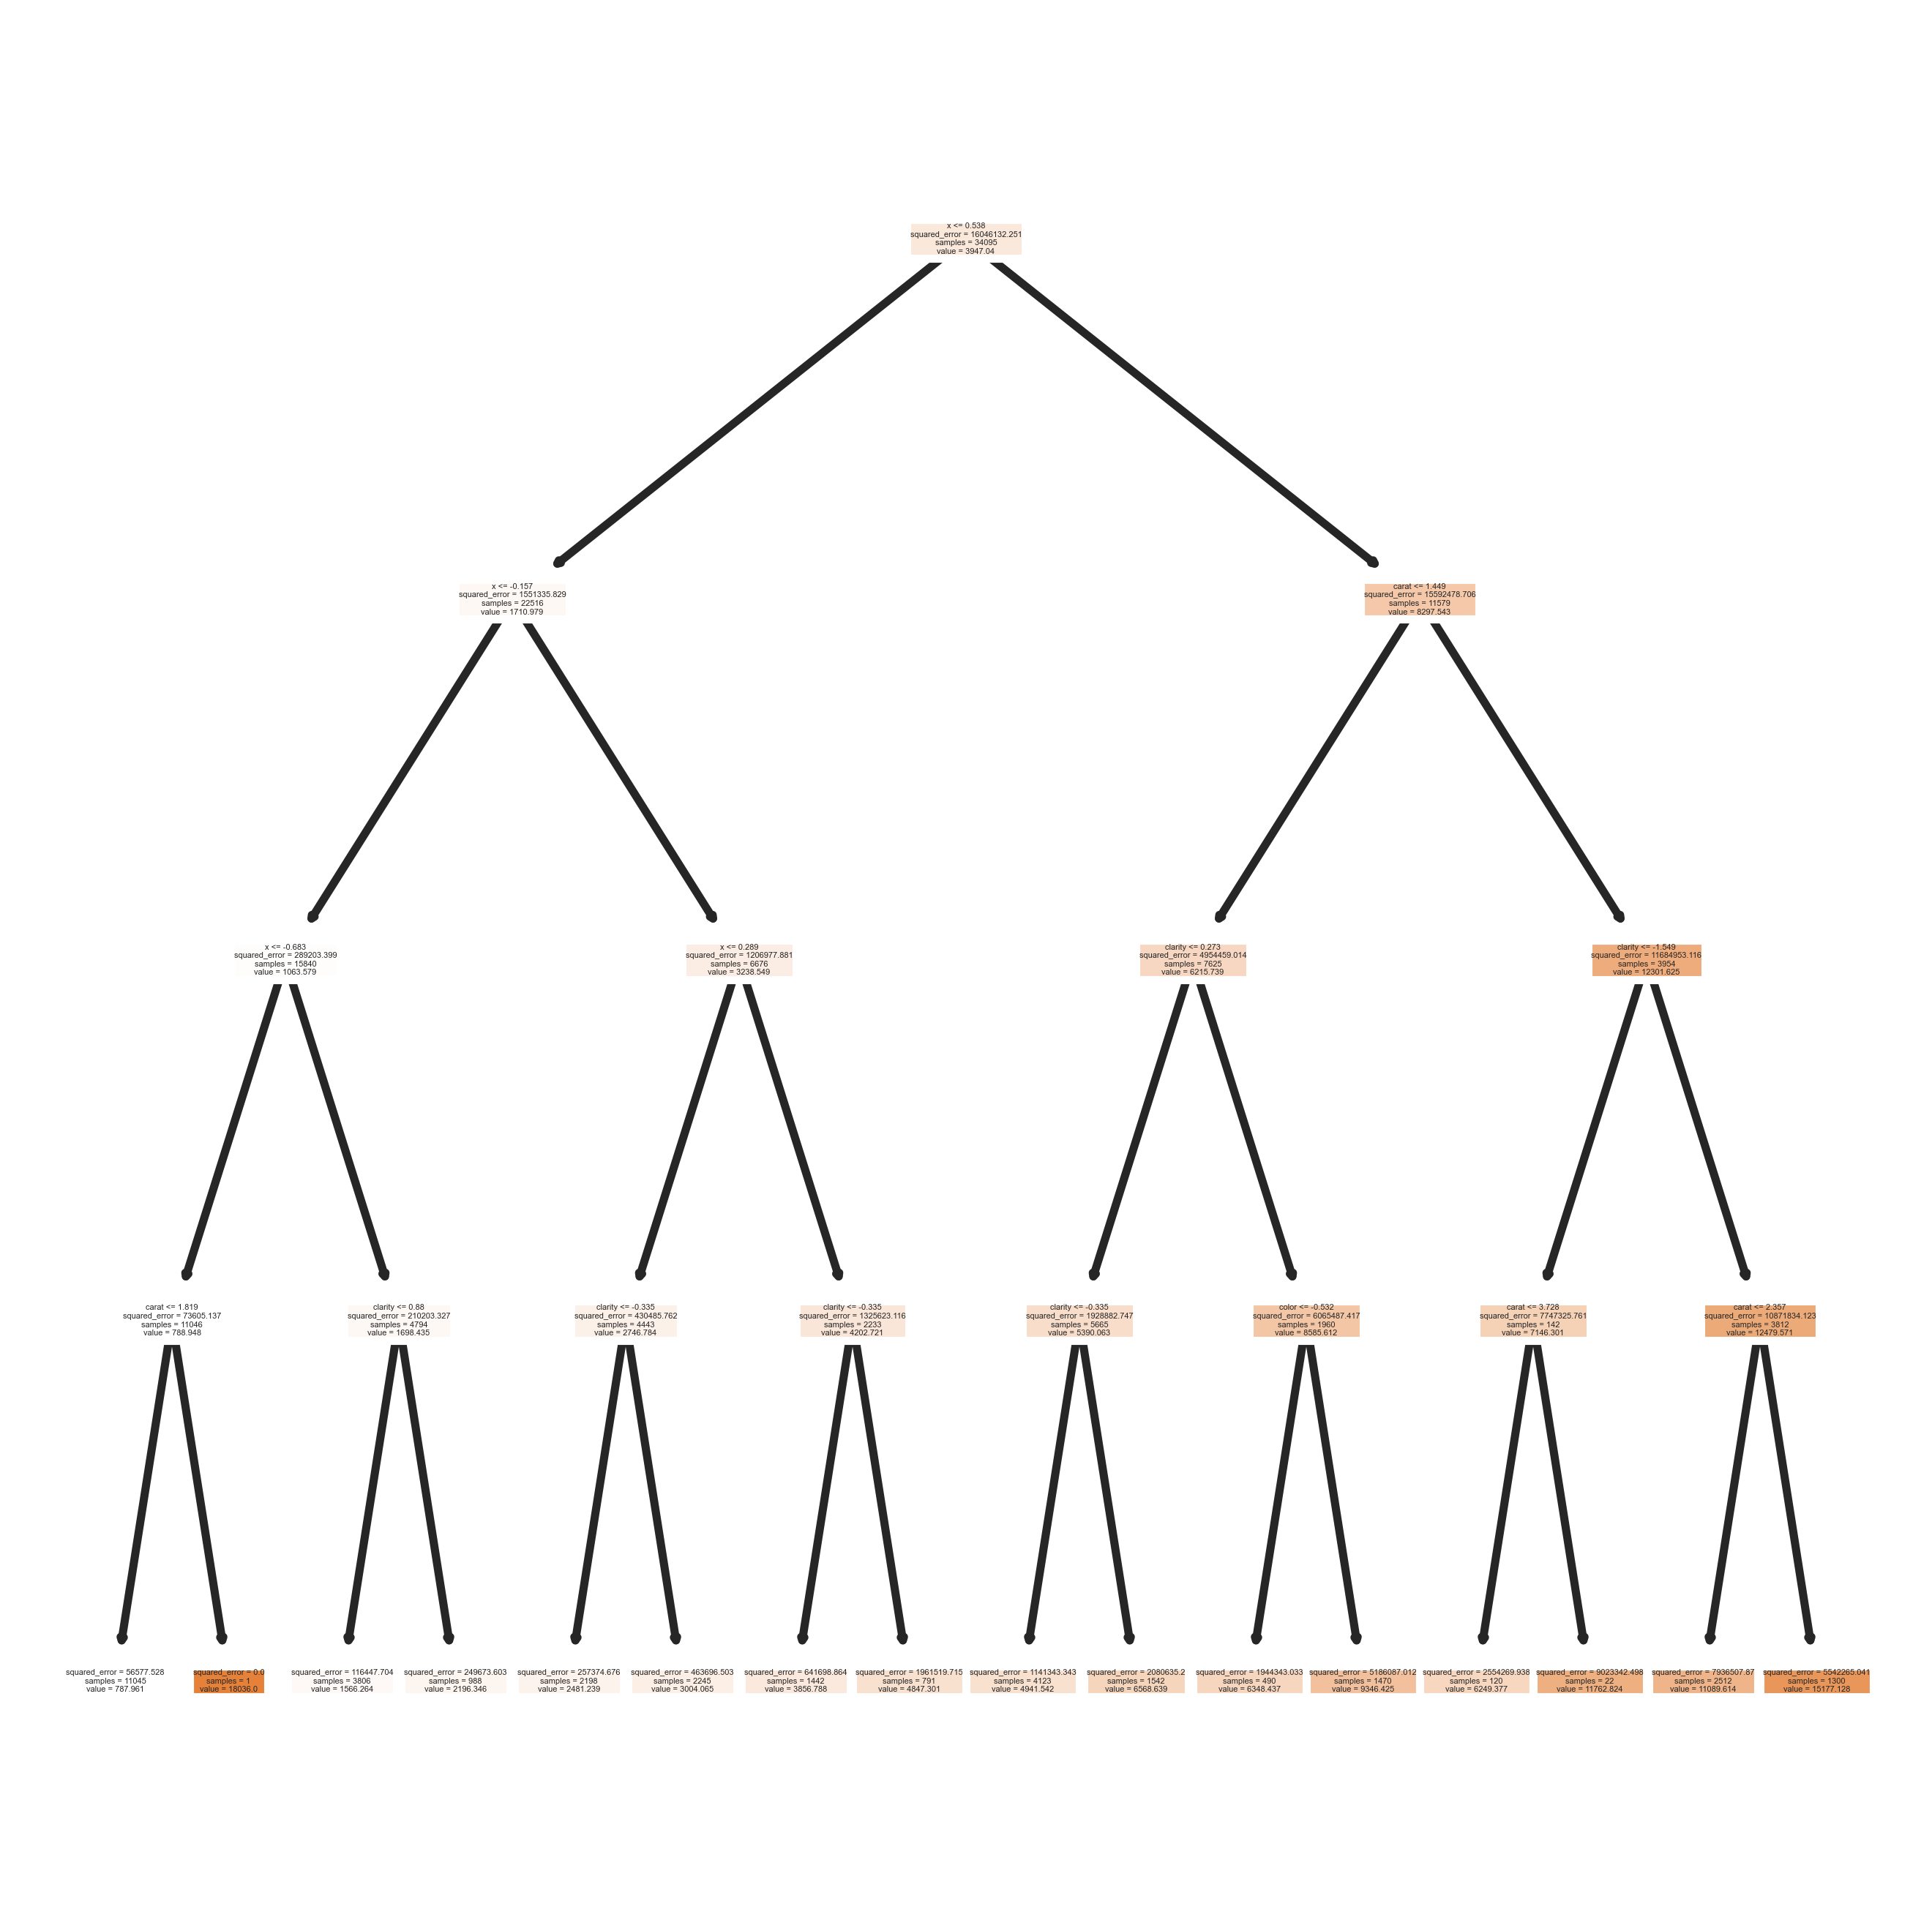

In [49]:
best_rf = grid_rf.best_estimator_
best_rf.fit(X, y)
fn = feat_cols
cn = targ_col
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi = 800)
tree.plot_tree(random.choice(best_rf.estimators_),
               feature_names = fn, 
               class_names = cn,
               filled = True)
plt.show()

The feature selected for branching at the root node is the x value. The imporance of this feature is that it is the feature that offers the highest information gain, whether the x dimension is less than or equal to a specific value. This is inline with what we found with the mutual information and f-score.  


## 7.4

In [50]:
best_rf = grid_rf.best_estimator_
train, test = train_test_split(df, test_size = 0.2)
X = train[feat_cols]
y = train[targ_col]
best_rf.fit(X, y)
ypred = best_rf.pred(test[feat_cols])
df_rf = pd.DataFrame({"Best Random Forest":[best_rf.oob_score_, 
                                            r2_score(y_true = test[targ_col], 
                                                     y_pred = ypred)]})
df_rf.index = ["OOB Score", "r2 score"]
df_rf

,Best Random Forest
OOB Score,0.923947


We see that the oob score is 0.926. This means that we are able to correctly predict 92.6% of the data. 


## Catboost

## 8.1

# lightgbm not working for me

In [51]:
#!pip install lightgbm
#import lightgbm as lgb

In [52]:
#!pip install catboost
#!pip install scikit-optimize
from catboost import CatBoostRegressor
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split
from skopt.space import Real, Integer

Some important hyperparameters are the learning_rate, depth, l2_leaf_ref, and the n_estimators. 
- learning_rate: determines the step size at each iteration. A small search space is possibly between 0.01 and 0.2
- depth: the depth of the tree. A small search space is between 5 and 10
- l2_leaf_reg: coefficient at the L2 regularization term. A small search space is between 1 and 10
- n_estimators: the number of trees in the entire model. A small search space is possibly between 50 and 1000

## 8.2

In [53]:
X = df[feat_cols]
y = df[targ_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size = 0.75, 
                                                    test_size = 0.25, 
                                                    random_state = 0)

model = CatBoostRegressor(verbose = False)
search = {'learning_rate': Real(0.01, 0.2, prior = 'log-uniform'),
          'depth': Integer(5, 10),
          'l2_leaf_reg': Integer(1, 10),
          'n_estimators': Integer(50, 1000),
         }

opt = BayesSearchCV(estimator = model, 
                    search_spaces = search, 
                    scoring = "neg_mean_squared_error", 
                    n_jobs = -1,
                    n_iter = 50,
                    cv = 10,
                   )

opt.fit(X_train, y_train)


AttributeError: 'BayesSearchCV' object has no attribute 'best_params'

In [56]:
print("Best Parameters:\n", opt.best_params_)
print("Best RMSE:", np.sqrt(-1 * opt.best_score_))

Best Parameters:
 OrderedDict([('depth', 8), ('l2_leaf_reg', 4), ('learning_rate', 0.05012794656775737), ('n_estimators', 897)])
Best RMSE: 534.1481054861895


## Question 8.3